### Section 4: 割引クーポンキャンペーンの効果最大化

ある雑貨店では、会員に対して定期的にDMを送って来客数の増加を狙っている。さらに客の来店率を高めるため、DMに店で使えるクーポンを付与することにした。限りある予算の中で、どの客(層)にどのくらいクーポンを配れば最も効果的なマーケティング施策を行えるだろうか。

### データの確認

（1）　会員データ（customers.csv）の確認

In [1]:
import pandas as pd
cust_df = pd.read_csv('customers.csv')
cust_df

,customer_id,age_cat,freq_cat
0,1,age20~34,freq2
1,2,age35~49,freq0
2,3,age35~49,freq0
3,4,age~19,freq0
4,5,age35~49,freq0
...,...,...,...
4995,4996,age50~,freq0
4996,4997,age50~,freq0
4997,4998,age35~49,freq1
4998,4999,age50~,freq1


In [2]:
ages = cust_df['age_cat'].unique()

In [3]:
freqs = cust_df['freq_cat'].unique()

<AxesSubplot:>

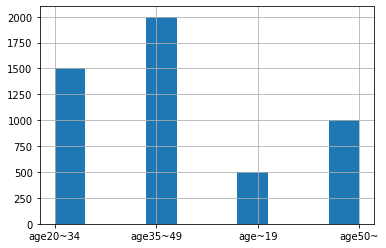

In [4]:
cust_df['age_cat'].hist()

<AxesSubplot:>

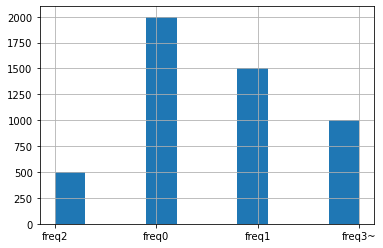

In [5]:
cust_df['freq_cat'].hist()

In [6]:
cust_pivot_df = pd.pivot_table(data=cust_df, values='customer_id', columns='freq_cat', index='age_cat', aggfunc='count')
cust_pivot_df = cust_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
cust_pivot_df

freq_cat,freq0,freq1,freq2,freq3~
age_cat,,,,
age~19,200,150,50,100
age20~34,600,450,150,300
age35~49,800,600,200,400
age50~,400,300,100,200


<AxesSubplot:xlabel='freq_cat', ylabel='age_cat'>

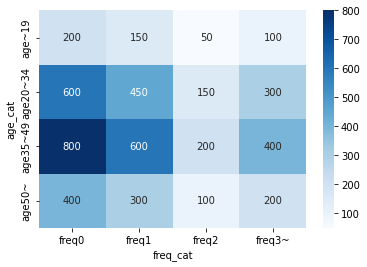

In [7]:
import seaborn as sns
sns.heatmap(cust_pivot_df, annot=True, fmt='d', cmap='Blues')

In [8]:
prob_df = pd.read_csv('visit_probability.csv')
prob_df

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74
3,age~19,freq3~,4,0.35,0.45,0.77
4,age20~34,freq0,5,0.11,0.17,0.37
5,age20~34,freq1,6,0.32,0.43,0.72
6,age20~34,freq2,7,0.42,0.55,0.93
7,age20~34,freq3~,8,0.52,0.63,0.94
8,age35~49,freq0,9,0.08,0.14,0.33
9,age35~49,freq1,10,0.25,0.35,0.67


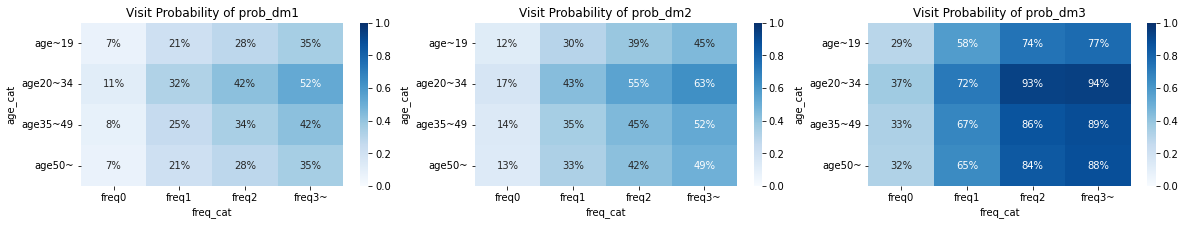

In [9]:
import matplotlib.pyplot as plt
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['prob_dm1', 'prob_dm2', 'prob_dm3']):
    prob_pivot_df = pd.pivot_table(data=prob_df, values=ptn, columns='freq_cat', index='age_cat')
    prob_pivot_df = prob_pivot_df.reindex (['age~19','age20~34', 'age35~49', 'age50~'])
    sns.heatmap(prob_pivot_df, vmin=0, vmax=1, annot=True, fmt='.0%', cmap='Blues', ax=ax[i])
    ax[i].set_title(f'Visit Probability of {ptn}')
plt.show()

### モデリング1：会員個別送付モデル

In [10]:
from mip import *

m = Model()

要件（1）　各会員に対してどのパターンのダイレクトメールを送付するかを決定

In [11]:
I = cust_df['customer_id'].tolist()
M = [1, 2, 3]

In [12]:
x = m.add_var(name='', var_type=BINARY)

In [13]:
# （1）各会員に対してどのパターンのダイレクトメールを送付するかを決定するための変数を用意
xim = {}
for i in I:
    for mm in M:
        xim[i,mm] = m.add_var(name=f'xim({i},{mm})', var_type=BINARY)
# 決定変数の数
len(xim)

15000

要件（2）　送付できるのは1 パターンのみ

In [14]:
for i in I:
        m += xsum(xim[i,mm] for mm in M) == 1

要件（3）　クーポン付与による来客増加数を最大化

In [15]:
keys = ['age_cat', 'freq_cat']
cust_prob_df = pd.merge(cust_df, prob_df)#, on=keys) -> keysをキーとして結合処理をする
cust_prob_df

,customer_id,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,1,age20~34,freq2,7,0.42,0.55,0.93
1,199,age20~34,freq2,7,0.42,0.55,0.93
2,200,age20~34,freq2,7,0.42,0.55,0.93
3,255,age20~34,freq2,7,0.42,0.55,0.93
4,269,age20~34,freq2,7,0.42,0.55,0.93
...,...,...,...,...,...,...,...
4995,4474,age~19,freq2,3,0.28,0.39,0.74
4996,4596,age~19,freq2,3,0.28,0.39,0.74
4997,4720,age~19,freq2,3,0.28,0.39,0.74
4998,4910,age~19,freq2,3,0.28,0.39,0.74


In [16]:
cust_prob_ver_df = cust_prob_df.rename(columns={'prob_dm1': 1, 'prob_dm2': 2, 'prob_dm3': 3})\
                  .melt(id_vars=['customer_id'], value_vars=[1,2,3], var_name='dm', value_name='prob')
cust_prob_ver_df

,customer_id,dm,prob
0,1,1,0.42
1,199,1,0.42
2,200,1,0.42
3,255,1,0.42
4,269,1,0.42
...,...,...,...
14995,4474,3,0.74
14996,4596,3,0.74
14997,4720,3,0.74
14998,4910,3,0.74


In [17]:
Pim = cust_prob_ver_df.set_index(['customer_id','dm'])['prob'].to_dict()

In [18]:
cust_prob_ver_df.set_index(['customer_id','dm'])['prob']

customer_id  dm
1            1     0.42
199          1     0.42
200          1     0.42
255          1     0.42
269          1     0.42
                   ... 
4474         3     0.74
4596         3     0.74
4720         3     0.74
4910         3     0.74
4947         3     0.74
Name: prob, Length: 15000, dtype: float64

In [19]:
# （3）クーポン付与による来客増加数を最大化
m.objective = maximize(xsum((Pim[i,mm] - Pim[i,1]) * xim[i,mm] for i in I for mm in [2,3]))

要件（4）　会員の予算消費期待値の合計は100 万円以下

In [20]:
Cm = {1:0, 2:1000, 3:2000}

# （4）顧客の消費する費用の期待値の合計は100万円以下
m += xsum(Cm[mm] * Pim[i,mm]* xim[i,mm] for i in I for mm in [2,3]) <= 1000000

# セグメントのリスト
S = prob_df['segment_id'].to_list()
print(f'S = {S}')

# 各セグメントとそのセグメントに属する顧客数を対応させる辞書の作成
Ns = cust_prob_df.groupby('segment_id')['customer_id'].count().to_dict()
print(f'Ns = {Ns}')

# 会員をキーとして属するセグメントを返す辞書
Si = cust_prob_df.set_index('customer_id')['segment_id'].to_dict()
#print(f'Si = {Si}')

# （5）各パターンのダイレクトメールをそれぞれのセグメントに属する会員数の10%以上送付
for s in S:
    for mm in M:
        m += xsum(xim[i,mm] for i in I if Si[i] == s) >= 0.1 * Ns[s]

S = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Ns = {1: 200, 2: 150, 3: 50, 4: 100, 5: 600, 6: 450, 7: 150, 8: 300, 9: 800, 10: 600, 11: 200, 12: 400, 13: 400, 14: 300, 15: 100, 16: 200}


In [21]:
import time
time_start = time.time()
status = m.optimize()
# gapRelを指定した場合はsolve関数にて上でパラメータを指定したsolverを引数にとる
# status = problem.solve(solver)
time_stop = time.time()

In [22]:
print(f'status:{OptimizationStatus(status)}')
print(f'objective function value:{m.objective.x:.4}')
print(f'elapsed time:{(time_stop - time_start):.3}(sec)')

status:OptimizationStatus.OPTIMAL
objective function value:326.1
elapsed time:13.0(sec)


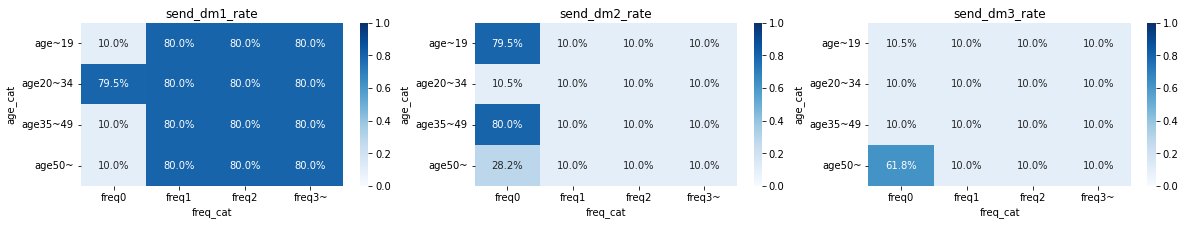

In [23]:
send_dm_df = pd.DataFrame([[xim[i,mm].x for mm in M] for i in I], columns=['send_dm1', 'send_dm2', 'send_dm3'])

cust_send_df = pd.concat([cust_df[['customer_id', 'age_cat', 'freq_cat']], send_dm_df], axis=1)

# 各セグメントに対するそれぞれのダイレクトメールの送付率
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_dm1', 'send_dm2', 'send_dm3']):
    cust_send_pivot_df = pd.pivot_table(data=cust_send_df, values=ptn, columns='freq_cat', index='age_cat', aggfunc='mean')
    cust_send_pivot_df = cust_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(cust_send_pivot_df, annot=True, fmt='.1%', cmap='Blues', vmin=0, vmax=1, ax=ax[i])
    ax[i].set_title(f'{ptn}_rate')
plt.show()

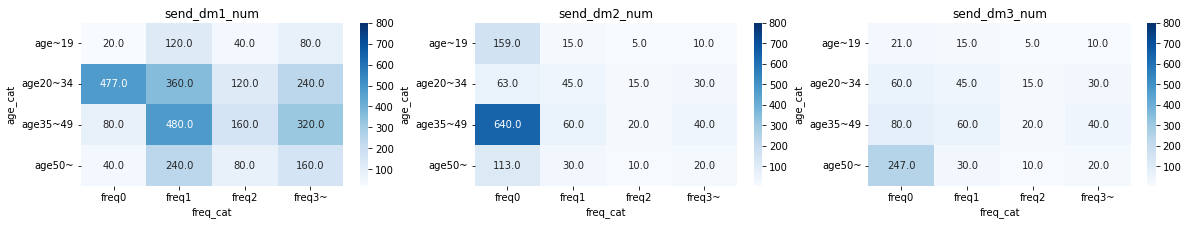

In [24]:
# 各セグメントに対するそれぞれのダイレクトメールの送付数
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_dm1', 'send_dm2', 'send_dm3']):
    cust_send_pivot_df = pd.pivot_table(data=cust_send_df, values=ptn, columns='freq_cat', index='age_cat',aggfunc='sum')
    cust_send_pivot_df = cust_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(cust_send_pivot_df, annot=True, fmt='.1f', cmap='Blues', vmax=800, ax=ax[i])
    ax[i].set_title(f'{ptn}_num')
plt.show()

### モデリング2：セグメント送付モデル

モデリング1では各個人に対して変数が定義されていたが、結局セグメント単位での最適化を行っている。そこで高速化のため変数を各個人ではなくセグメントごとにとることにする。最適化の結果はモデリング1と同様となることが期待される。

In [25]:
m2 = Model()

# （1）各会員に対してどのパターンのダイレクトメールを送付するかを決定するための変数を用意
# xsm[2,3] = セグメント2に対するパターン3のクーポンの送付率
xsm = {}
for s in S:
    for mm in M:
        xsm[s,mm] = m2.add_var(name=f'xim({s},{mm})', lb=0.0, ub=1.0, var_type=CONTINUOUS)
# 決定変数の数
print(f'# of variables = {len(xsm)}')



# （2）各会員に対して送付するダイレクトメールはいずれか1パターン
# 即ち　sum_{M}(一つのセグメントsに対するクーポンmm送付率) = 100%
for s in S:
    m2 += xsum(xsm[s,mm] for mm in M) == 1
    
    
prob_ver_df = prob_df.rename(columns={'prob_dm1': 1,'prob_dm2': 2, 'prob_dm3': 3})\
.melt(id_vars=['segment_id'], value_vars=[1,2,3], var_name='dm', value_name='prob')
Psm = prob_ver_df.set_index(['segment_id','dm'])['prob'].to_dict()

# （3）クーポン付与による来客増加数を最大化
# 来客増加数 = セグメント所属人数 * クーポン受け取りによる来店率の増加率 * クーポン送付率
m2.objective = maximize(xsum(Ns[s] * (Psm[s,mm] - Psm[s,1]) * xsm[s,mm] for s in S for mm in [2,3]))

# （4）会員の予算消費期待値の合計は100万円以下
# 予算消費期待値 = クーポン発行コスト * セグメント所属人数 * クーポン受け取り後期待来店率(クーポン使用率) * クーポン送付率
m2 += xsum(Cm[mm] * Ns[s] * Psm[s,mm] * xsm[s,mm] for s in S for mm in [2,3]) <= 1000000

# （5）各パターンのダイレクトメールをそれぞれのセグメントに属する会員数の10%以上送付
for s in S:
    for mm in M:
        m2 += xsm[s,mm] >= 0.1


# of variables = 48


In [26]:
time_start = time.time()
status = m2.optimize()
# gapRelを指定した場合はsolve関数にて上でパラメータを指定したsolverを引数にとる
# status = problem.solve(solver)
time_stop = time.time()

print(f'status:{OptimizationStatus(status)}')
print(f'objective function value:{m2.objective.x:.4}')
print(f'elapsed time:{(time_stop - time_start):.3}(sec)')

status:OptimizationStatus.OPTIMAL
objective function value:326.1
elapsed time:0.054(sec)


--> モデリング1と同様の結果が得られた上、実行時間が短縮されている。

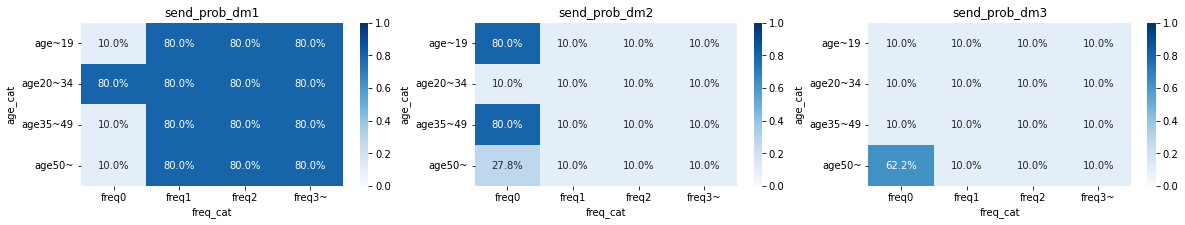

In [27]:
send_dm_df = pd.DataFrame([[xsm[s,mm].x for mm in M] for s in S], columns=['send_prob_dm1', 'send_prob_dm2','send_prob_dm3'])
seg_send_df = pd.concat([prob_df[['segment_id', 'age_cat', 'freq_cat']], send_dm_df], axis=1)
# 各セグメントに対するそれぞれのダイレクトメールの送付率
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_prob_dm1', 'send_prob_dm2', 'send_prob_dm3']):
    seg_send_pivot_df = pd.pivot_table(data=seg_send_df,values=ptn, columns='freq_cat', index='age_cat', aggfunc='mean')
    seg_send_pivot_df = seg_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(seg_send_pivot_df, annot=True, fmt='.1%', cmap='Blues', vmin=0, vmax=1, ax=ax[i])
    ax[i].set_title(f'{ptn}')
plt.show()

In [28]:
seg_send_df['num_cust'] = seg_send_df['segment_id'].apply(lambda x: Ns[x])
seg_send_df['send_num_dm1'] = seg_send_df['send_prob_dm1']*seg_send_df['num_cust']
seg_send_df['send_num_dm2'] = seg_send_df['send_prob_dm2']*seg_send_df['num_cust']
seg_send_df['send_num_dm3'] = seg_send_df['send_prob_dm3']*seg_send_df['num_cust']
seg_send_df[['segment_id','send_num_dm1','send_num_dm2','send_num_dm3']].head()

,segment_id,send_num_dm1,send_num_dm2,send_num_dm3
0,1,20.0,160.0,20.0
1,2,120.0,15.0,15.0
2,3,40.0,5.0,5.0
3,4,80.0,10.0,10.0
4,5,480.0,60.0,60.0


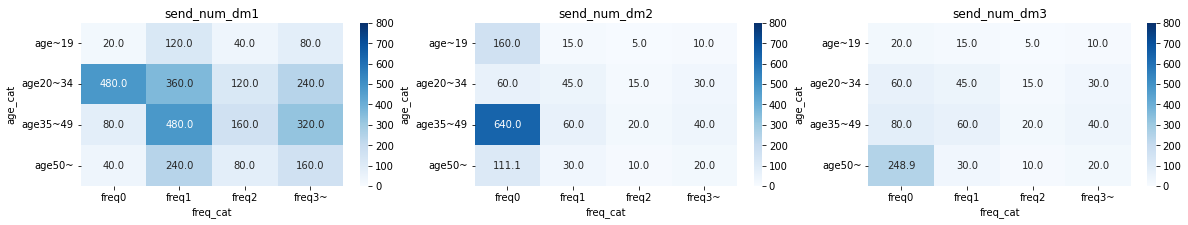

In [29]:
# 各セグメントに対するそれぞれのダイレクトメールの送付数
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_num_dm1','send_num_dm2','send_num_dm3']):
    seg_send_pivot_df = pd.pivot_table(data=seg_send_df,values=ptn, columns='freq_cat', index='age_cat')
    seg_send_pivot_df = seg_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(seg_send_pivot_df, annot=True, fmt='.1f', cmap='Blues', vmin=0, vmax=800, ax=ax[i])
    ax[i].set_title(f'{ptn}')
plt.show()

### モデリング3：送付率下限値最大化モデル

モデリング1と2では想定通り同様の結果が得られた。各セグメントごとのクーポン送付率をみると、80%近く送っているセグメントと、下限の10%しか送っていないところに分けられていることがわかる。中長期的に来客を確保するという観点からは、このような極端なクーポンの配布の仕方は適切だろうか？

そこで、送付率の下限を最大化するような最適化を考えてみる。

In [30]:
m3 = Model()

In [31]:
#　（1）各セグメントへのそれぞれパターンのダイレクトメールの送付率の下限値と
# 各会員に対してどのダイレクトメールを送付するかを決定
# 会員に対してどのダイレクトメールを送付するか
xsm = {}
#　［0,1］の変数を宣言
for s in S:
    for mm in M:
        xsm[s,mm] = m3.add_var(name=f'xsm({s},{mm})', lb=0, ub=1, var_type=CONTINUOUS)
# 各セグメントへのそれぞれパターンのダイレクトメールの送付率の下限値
y = m3.add_var(name='y', lb=0, ub=1, var_type=CONTINUOUS)

#　（3）各セグメントへのそれぞれパターンのダイレクトメールの送付率の下限値を最大化
m3.objective = maximize(y)

#　（5）各パターンのダイレクトメールを設定した送付率の下限値以上送付
for s in S:
    for mm in M:
        m3 += xsm[s,mm] >= y
        
#　（2）各会員に対して送付するダイレクトメールはいずれか1パターン
for s in S:
    m3 += xsum(xsm[s,mm] for mm in M) == 1

#　（4）会員の予算消費期待値の合計は100万円以下
m3 += xsum(Cm[mm] * Ns[s] * Psm[s,mm] * xsm[s,mm] for s in S for mm in [2,3]) <= 1000000

In [32]:
time_start = time.time()
status = m3.optimize()
# gapRelを指定した場合はsolve関数にて上でパラメータを指定したsolverを引数にとる
# status = problem.solve(solver)
time_stop = time.time()

max_lb = m3.objective.x

print(f'status:{OptimizationStatus(status)}')
print(f'maximum lowerbound:{max_lb:.4}')
print(f'elapsed time:{(time_stop - time_start):.3}(sec)')

status:OptimizationStatus.OPTIMAL
maximum lowerbound:0.1313
elapsed time:0.032(sec)


下限送付割合の最大値がわかった。

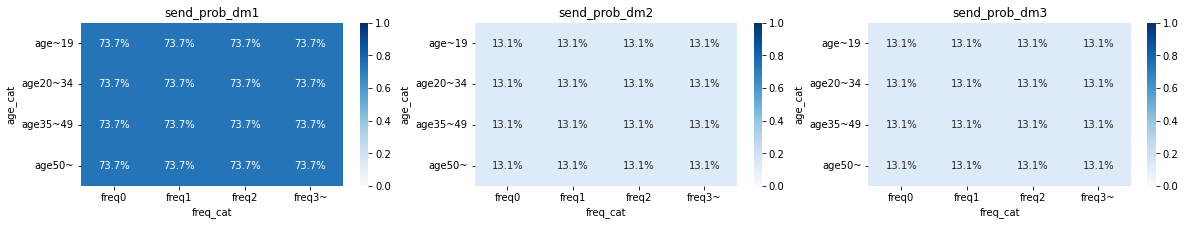

In [33]:
send_dm_df = pd.DataFrame([[xsm[s,mm].x for mm in M]for s in S], columns=['send_prob_dm1', 'send_prob_dm2','send_prob_dm3'])
seg_send_df = pd.concat([prob_df[['segment_id', 'age_cat', 'freq_cat']], send_dm_df], axis=1)
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_prob_dm1', 'send_prob_dm2', 'send_prob_dm3']):
    seg_send_pivot_df = pd.pivot_table(data=seg_send_df,values=ptn, columns='freq_cat',index='age_cat', aggfunc='mean')
    seg_send_pivot_df = seg_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(seg_send_pivot_df, annot=True, fmt='.1%', cmap='Blues', vmin=0, vmax=1, ax=ax[i])
    ax[i].set_title(f'{ptn}')
plt.show()

この下限送付割合を用いて、期待来客数を最大化する送付割合を決定する。

In [34]:
# 数理モデルのインスタンス作成
m3_2 = Model()
#　（1）各セグメントへのそれぞれパターンのダイレクトメールの送付率の下限値と各会員に対してどのダイレクトメールを送付するかを決定
# 会員に対してどのダイレクトメールを送付するか
x = {}
#　［0,1］の変数を宣言
for s in S:
    for mm in M:
        xsm[s,mm] = m3_2.add_var(name=f'xsm({s},{mm})',lb=0, ub=1, var_type=CONTINUOUS)
#　（2）各会員に対して送付するダイレクトメールはいずれか1パターン
for s in S:
    m3_2 += xsum(xsm[s,mm] for mm in M) == 1
#　（3）クーポン付与による来客増加数を最大化
m3_2.objective = maximize(xsum(Ns[s] * (Psm[s,mm] - Psm[s,1]) * xsm[s,mm] for s in S for mm in [2,3]))
#　（4）会員の予算消費期待値の合計は100万円以下
m3_2 += xsum(Cm[mm] * Ns[s] * Psm[s,mm] * xsm[s,mm] for s in S for mm in [2,3]) <= 1000000
#　（5）各パターンのダイレクトメールを設定した送付率の下限値以上送付
for s in S:
    for mm in M:
        m3_2 += xsm[s,mm] >= max_lb


In [35]:
time_start = time.time()
status = m3_2.optimize()
# gapRelを指定した場合はsolve関数にて上でパラメータを指定したsolverを引数にとる
# status = problem.solve(solver)
time_stop = time.time()

print(f'status:{OptimizationStatus(status)}')
print(f'objective function value:{m3_2.objective.x:.4}')
print(f'elapsed time:{(time_stop - time_start):.3}(sec)')

status:OptimizationStatus.OPTIMAL
objective function value:300.6
elapsed time:0.046(sec)


### 投資対効果の評価

In [36]:
cost_list = []
cpa_list = []
inc_action_list = []

In [39]:
print('ステータス, キャンペーン費用, 来客増加数, CPA')
for cost in range(761850, 3000000, 100000):
    m4 = Model()

    # （1）各会員に対してどのパターンのダイレクトメールを送付するかを決定するための変数を用意
    # xsm[2,3] = セグメント2に対するパターン3のクーポンの送付率
    xsm = {}
    for s in S:
        for mm in M:
            xsm[s,mm] = m4.add_var(name=f'xim({s},{mm})', lb=0.0, ub=1.0, var_type=CONTINUOUS)

    # （2）各会員に対して送付するダイレクトメールはいずれか1パターン
    # 即ち　sum_{M}(一つのセグメントsに対するクーポンmm送付率) = 100%
    for s in S:
        m4 += xsum(xsm[s,mm] for mm in M) == 1
    
    #prob_ver_df = prob_df.rename(columns={'prob_dm1': 1,'prob_dm2': 2, 'prob_dm3': 3})\
    #.melt(id_vars=['segment_id'], value_vars=[1,2,3], var_name='dm', value_name='prob')
    #Psm = prob_ver_df.set_index(['segment_id','dm'])['prob'].to_dict()

    # （3）クーポン付与による来客増加数を最大化
    # 来客増加数 = セグメント所属人数 * クーポン受け取りによる来店率の増加率 * クーポン送付率
    m4.objective = maximize(xsum(Ns[s] * (Psm[s,mm] - Psm[s,1]) * xsm[s,mm] for s in S for mm in [2,3]))

    # （4）会員の予算消費期待値の合計は100万円以下
    # 予算消費期待値 = クーポン発行コスト * セグメント所属人数 * クーポン受け取り後期待来店率(クーポン使用率) * クーポン送付率
    m4 += xsum(Cm[mm] * Ns[s] * Psm[s,mm] * xsm[s,mm] for s in S for mm in [2,3]) <= cost

    # （5）各パターンのダイレクトメールをそれぞれのセグメントに属する会員数の10%以上送付
    for s in S:
        for mm in M:
            m4 += xsm[s,mm] >= 0.1
            
    
    status = m4.optimize()
    cpa = cost/m4.objective.x
    inc_action = m4.objective.x
    cost_list.append(cost)
    cpa_list.append(cpa)
    inc_action_list.append(inc_action)
    print(f'{OptimizationStatus(status)}, {cost}, {inc_action :.4}, {cpa :.5}')

ステータス, キャンペーン費用, 来客増加数, CPA
OptimizationStatus.OPTIMAL, 761850, 229.0, 3326.9
OptimizationStatus.OPTIMAL, 861850, 273.1, 3156.3
OptimizationStatus.OPTIMAL, 961850, 311.9, 3084.0
OptimizationStatus.OPTIMAL, 1061850, 349.1, 3042.0
OptimizationStatus.OPTIMAL, 1161850, 385.8, 3011.8
OptimizationStatus.OPTIMAL, 1261850, 422.3, 2988.0
OptimizationStatus.OPTIMAL, 1361850, 458.8, 2968.0
OptimizationStatus.OPTIMAL, 1461850, 495.2, 2951.8
OptimizationStatus.OPTIMAL, 1561850, 530.5, 2944.2
OptimizationStatus.OPTIMAL, 1661850, 565.6, 2938.4
OptimizationStatus.OPTIMAL, 1761850, 600.7, 2933.2
OptimizationStatus.OPTIMAL, 1861850, 634.2, 2935.9
OptimizationStatus.OPTIMAL, 1961850, 667.3, 2940.2
OptimizationStatus.OPTIMAL, 2061850, 700.2, 2944.5
OptimizationStatus.OPTIMAL, 2161850, 732.5, 2951.4
OptimizationStatus.OPTIMAL, 2261850, 764.1, 2960.1
OptimizationStatus.OPTIMAL, 2361850, 795.5, 2969.2
OptimizationStatus.OPTIMAL, 2461850, 826.8, 2977.5
OptimizationStatus.OPTIMAL, 2561850, 858.1, 2985.3
Optimi

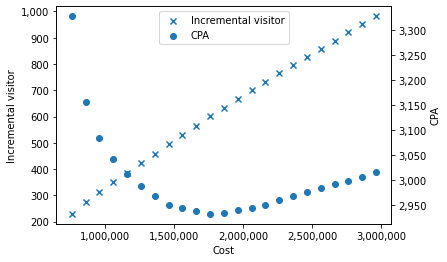

In [40]:
import matplotlib.ticker as ticker
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.scatter(cost_list, inc_action_list, marker='x', label='Incremental visitor')
ax2.scatter(cost_list, cpa_list, label='CPA')
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x :,.0f}'))
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x :,.0f}'))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x :,.0f}'))
ax1.set_xlabel('Cost')
ax1.set_ylabel('Incremental visitor')
ax2.set_ylabel('CPA')
reg1, label1 = ax1.get_legend_handles_labels()
reg2, label2 = ax2.get_legend_handles_labels()
ax2.legend(reg1 + reg2, label1 + label2, loc='upper center')
plt.show()